In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from models import *
from data_generation import *
from utils import *
from skfda.representation.grid import FDataGrid
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.preprocessing.dim_reduction import FPCA

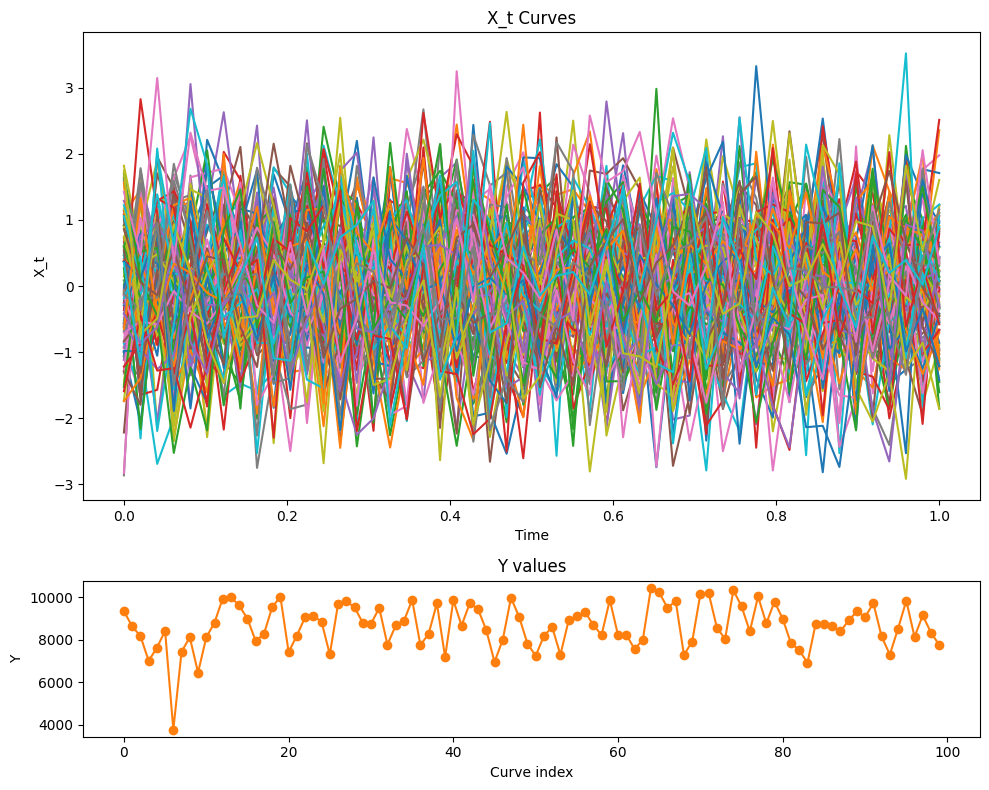

Dimension of X: (50, 100)
Dimension of Y: (100,)


In [2]:
d=100; J=6; n=50; lambda_param=10; alpha=5; sigma=1.0
time_grid = np.linspace(0, 1, n)
X_np, Y_np = generate_Y_case3(d, n, J,lambda_param, alpha, sigma, plot=True)
print("Dimension of X:", X_np.shape)
print("Dimension of Y:", Y_np.shape)


In [3]:
#Step 1: Fit B-spline basis functions to each curve
fd = FDataGrid(data_matrix = X_np.T, grid_points = time_grid)
n_basis = 8  # Number of basis functions
spline_basis = BSplineBasis(n_basis=n_basis, domain_range=(0, 1))
smoother = BasisSmoother(basis=spline_basis)

In [4]:
# Apply smoothing to each curve (column of x)
smoothed_fd = smoother.fit_transform(fd)

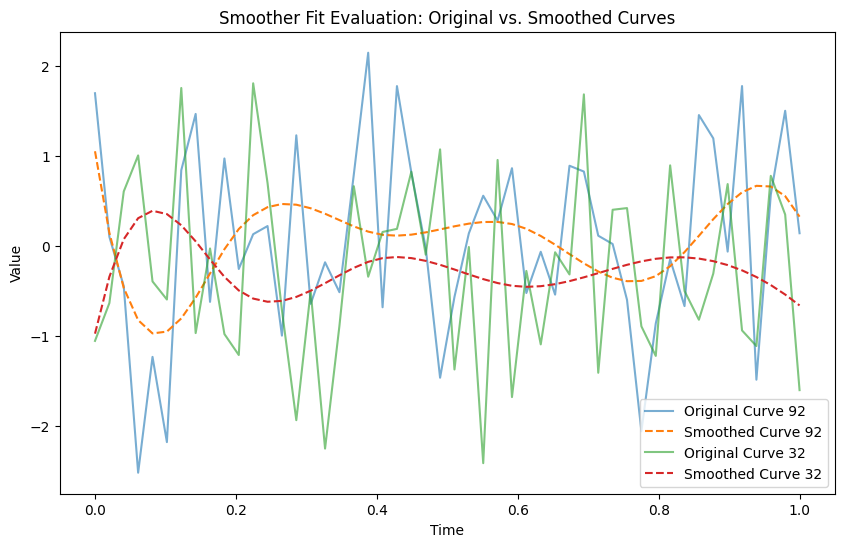

In [5]:
num_curves_to_plot = 2  # Number of curves to visualize
selected_indices = np.random.choice(fd.n_samples, size=num_curves_to_plot, replace=False)  # Randomly select curves

plt.figure(figsize=(10, 6))
for idx in selected_indices:
    original_curve = fd.data_matrix[idx]
    smoothed_curve = smoothed_fd.data_matrix[idx]
    
    plt.plot(fd.grid_points[0], original_curve.flatten(), label=f"Original Curve {idx}", alpha=0.6)
    plt.plot(smoothed_fd.grid_points[0], smoothed_curve.flatten(), label=f"Smoothed Curve {idx}", linestyle="--")
    
plt.title("Smoother Fit Evaluation: Original vs. Smoothed Curves")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.show()

In [6]:
fpca = FPCA(n_components=8)  
fpca.fit(smoothed_fd)
scores = fpca.transform(smoothed_fd)
# Explained variance ratio
print("Explained variance by each PC:", fpca.explained_variance_ratio_)
sum(fpca.explained_variance_ratio_)

Explained variance by each PC: [0.29903941 0.1535282  0.12652674 0.11401254 0.1005505  0.09623671
 0.05695104 0.05315486]


1.0

In [7]:
X = torch.tensor(scores.T, dtype=torch.float32) 
X.size()

torch.Size([8, 100])

In [8]:
Y = torch.tensor(Y_np, dtype=torch.float32).view(1, d)
Y.size()

torch.Size([1, 100])

# Model with long-run covariance matrix

Epoch [100/5000], Loss: 707763.5000
Epoch [200/5000], Loss: 5.3368
Epoch [300/5000], Loss: 0.0002
Stopping early at Epoch [305/5000], Loss: 0.000087


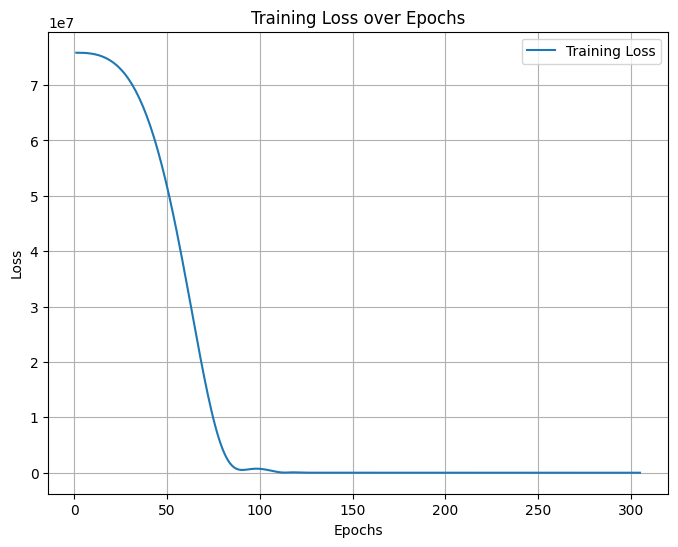

In [9]:
q = int(n ** (1/5))  # Setting q as n^(1/5)
h = 1.0  # Example bandwidth

# Define the weight network and the main model
weight_net = WeightNetwork(input_dim=1)  # Neural network to estimate weights
cov_matrix = LR_cov_X(X, q, h, weight_net)  # Long-run covariance matrix with learned weights

x_shape_0 = X.shape[0]
x_shape_1 = X.shape[1]
hidden_dim = 32  # Example hidden layer size
y_shape_0 = Y.shape[0]
y_shape_1 = Y.shape[1]
cov_dim = d

model = Model1(x_shape_0,x_shape_1, cov_dim, hidden_dim, y_shape_0,y_shape_1)
criterion = nn.MSELoss()
optimizer = optim.Adam(list(model.parameters()) + list(weight_net.parameters()), lr=0.02)

# Training loop
epochs = 5000
losses = [] 
for epoch in range(epochs):
    optimizer.zero_grad()
    cov_matrix = LR_cov_X(X, q, h, weight_net)  # Recompute covariance matrix with updated weights
    Y_hat = model(X, cov_matrix)  # Predicted Y(t)
    #print(Y_hat.shape)
    #print(Y.shape)
    loss = criterion(Y_hat, Y)  # Minimize L2 loss between Y_hat and Y
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Check for stopping condition
    if abs(loss.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
        break  # Exit the loop when the loss is sufficiently small


    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')
        
# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses) + 1),  losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

tensor([[ 0.0375, -0.0044, -0.0050,  0.0026,  0.0013,  0.0003,  0.0028,  0.0017],
        [-0.0044,  0.0133,  0.0005, -0.0045, -0.0013, -0.0006, -0.0018, -0.0023],
        [-0.0050,  0.0005,  0.0075, -0.0047, -0.0035,  0.0016, -0.0022,  0.0013],
        [ 0.0026, -0.0045, -0.0047,  0.0132,  0.0028, -0.0001,  0.0022, -0.0002],
        [ 0.0013, -0.0013, -0.0035,  0.0028,  0.0117, -0.0006,  0.0014,  0.0013],
        [ 0.0003, -0.0006,  0.0016, -0.0001, -0.0006,  0.0111, -0.0017,  0.0009],
        [ 0.0028, -0.0018, -0.0022,  0.0022,  0.0014, -0.0017,  0.0042,  0.0009],
        [ 0.0017, -0.0023,  0.0013, -0.0002,  0.0013,  0.0009,  0.0009,  0.0028]])
(100,)


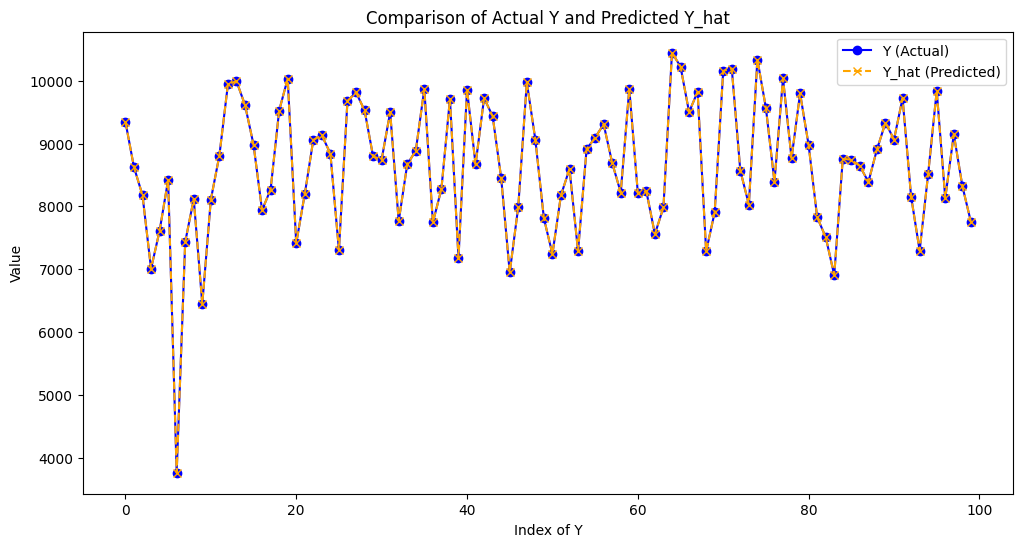

In [10]:
# After training, compute the final predictions for plotting
with torch.no_grad():
    cov_matrix = LR_cov_X(X, q, h, weight_net)
    print(cov_matrix)
    Y_hat = model(X, cov_matrix).view(-1).detach().numpy()  # Ensure Y_hat is flattened to match (d,)
    print(np.shape(Y_hat))
    Y_actual = Y.view(-1).numpy()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(d), Y_actual, label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(d), Y_hat, label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')
plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()

In [11]:
import os

# Ensure the results directory exists
results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

# Convert the tensor to a NumPy array and save it as a CSV file
cov_matrix_np = cov_matrix.cpu().numpy()  # Convert to NumPy (ensure on CPU first)
csv_path = os.path.join(results_dir, "cov_matrix_case3.csv")

# Save as CSV
np.savetxt(csv_path, cov_matrix_np, delimiter=",", fmt="%.6f")  # Adjust `fmt` for precision

print(f"Covariance matrix saved to {csv_path}")

Covariance matrix saved to results/cov_matrix_case3.csv


# Model without long-run covariance matrix

Epoch [100/1000], Loss: 493690.3125
Epoch [200/1000], Loss: 14.9408
Epoch [300/1000], Loss: 0.0010
Stopping early at Epoch [320/1000], Loss: 0.000096


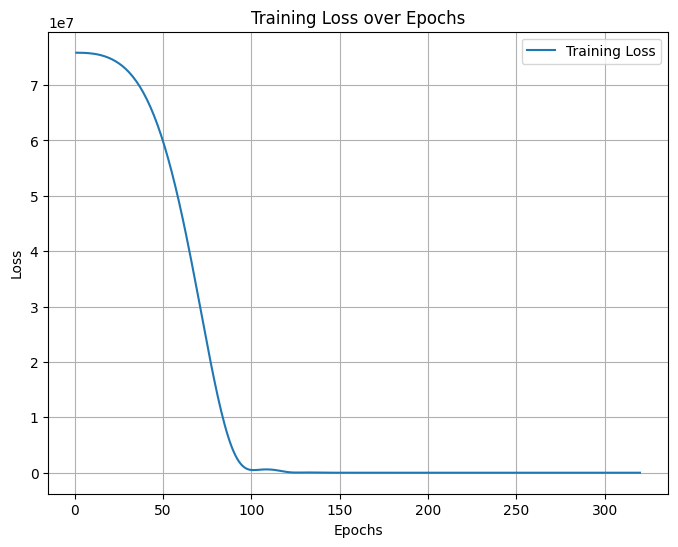

In [12]:
hidden_dim = 32
model_nocov = Model1_nocov(x_shape_0,x_shape_1, hidden_dim , y_shape_0,y_shape_1)
criterion_nocov = nn.MSELoss()
optimizer_nocov = optim.Adam(list(model_nocov.parameters()) , lr=0.02)

# Training loop
epochs = 1000
losses_nocov = []
for epoch in range(epochs):
    optimizer_nocov.zero_grad()
    #cov_matrix = LR_cov_X(X, q, h, weight_net)  # Recompute covariance matrix with updated weights
    Y_hat_nocov = model_nocov(X)  # Predicted Y(t)
    #print(Y_hat.shape)
    #print(Y.shape)
    loss_nocov = criterion_nocov(Y_hat_nocov, Y)  # Minimize L2 loss between Y_hat and Y
    loss_nocov.backward()
    optimizer_nocov.step()
    losses_nocov.append(loss_nocov.item())

    # Check for stopping condition
    if abs(loss_nocov.item()) < 1e-4:
        print(f"Stopping early at Epoch [{epoch+1}/{epochs}], Loss: {loss_nocov.item():.6f}")
        break  # Exit the loop when the loss is sufficiently small


    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss_nocov.item():.4f}')
        
# Plot the loss curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(losses_nocov) + 1),  losses_nocov, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.grid()
plt.show()

(100,)


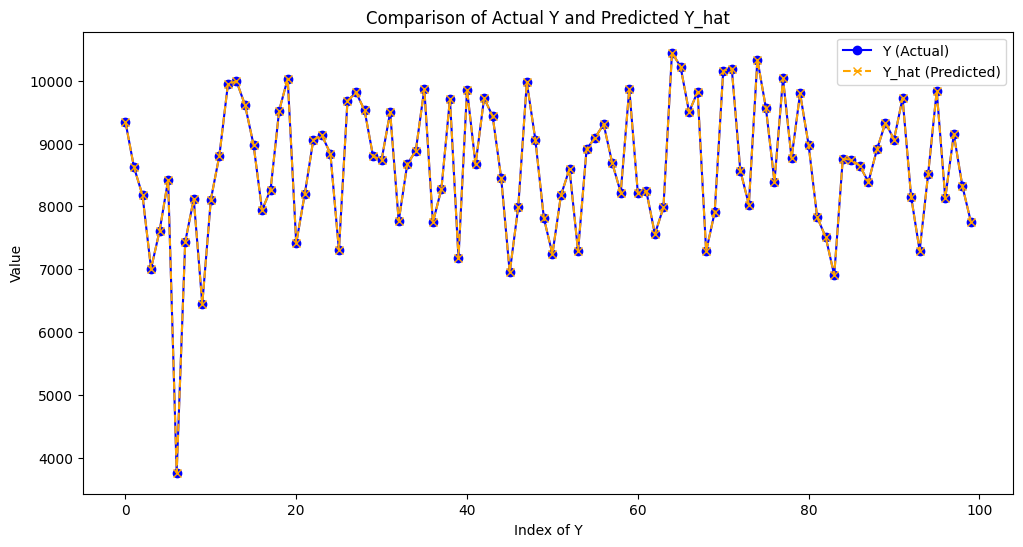

In [13]:
# After training, compute the final predictions for plotting
with torch.no_grad():
    Y_hat_nocov = model_nocov(X).view(-1).detach().numpy()  # Ensure Y_hat is flattened to match (d,)
    print(np.shape(Y_hat))
    Y_actual = Y.view(-1).numpy()  # Flatten Y to (d,)

# Plotting Y and Y_hat
plt.figure(figsize=(12, 6))
plt.plot(range(d), Y_actual, label='Y (Actual)', marker='o', linestyle='-', color='blue')
plt.plot(range(d), Y_hat_nocov, label='Y_hat (Predicted)', marker='x', linestyle='--', color='orange')
plt.xlabel("Index of Y")
plt.ylabel("Value")
plt.title("Comparison of Actual Y and Predicted Y_hat")
plt.legend()
plt.show()